In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging
import copy

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from core_data_prep.core_data_prep import DataPreparer
from core_data_prep.validations import Validator

from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from data.raw.retrievers.stooq_retriever import StooqRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor, FullyConnectedBackend, TransformerBackend
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
str(config.data_config.frequency)

'1Day'

In [3]:
retriever = StooqRetriever(download_from_gdrive=False)
initial_state = config.model_config.model.state_dict()

In [4]:
def evaluate_signal_predictor(end_date: datetime, train_set_last_date: datetime, val_set_last_date: datetime, model=None):
    print(f'Running experiment for {config.data_config.start} to {end_date} with train set last date {train_set_last_date} and val set last date {val_set_last_date}')
    
    retrieval_result = retriever.bars(start=config.data_config.start, end=end_date)

    data_preparer = DataPreparer(
        normalizer=config.data_config.normalizer,
        missing_values_handler=config.data_config.missing_values_handler,
        in_seq_len=config.data_config.in_seq_len,
        frequency=str(config.data_config.frequency),
        validator=Validator(),
        backend='threading'
    )

    (X_train, y_train, statistics_train), (X_val, y_val, statistics_val), (X_test, y_test, statistics_test) = \
        data_preparer.get_experiment_data(
            data=retrieval_result,
            start_date=None,
            end_date=None,
            features=config.data_config.features,
            statistics=config.data_config.statistics,
            target=config.data_config.target,
            train_set_last_date=train_set_last_date,
            val_set_last_date=val_set_last_date,
        )
    next_return_train, spread_train, volatility_train, \
        next_return_val, spread_val, volatility_val, \
        next_return_test, spread_test, volatility_test = \
            statistics_train['next_return'], statistics_train['spread'], statistics_train['volatility'], \
            statistics_val['next_return'], statistics_val['spread'], statistics_val['volatility'], \
            statistics_test['next_return'], statistics_test['spread'], statistics_test['volatility']
        
    print(X_train.shape, y_train.shape, next_return_train.shape, spread_train.shape, volatility_train.shape, X_test.shape,\
         y_test.shape, next_return_test.shape, spread_test.shape, volatility_test.shape)

    if not model: 
        print('Training model...')
        train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )
        val_loader = DatasetPytorch(X_val, y_val, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )

        model = config.model_config.model
        model.load_state_dict(initial_state)

        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_fn=config.train_config.loss_fn,
            optimizer=config.train_config.optimizer,
            scheduler=config.train_config.scheduler,
            num_epochs=config.train_config.num_epochs,
            early_stopping_patience=config.train_config.early_stopping_patience,
            device=config.train_config.device,
            metrics=config.train_config.metrics,
            save_path=config.train_config.save_path
        )

        model, history = trainer.train()
    else: 
        print('Using existing model...')

    trajectory_length = 30
    test_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, volatility_test, trajectory_length=trajectory_length).as_dataloader(
        batch_size=8, 
        shuffle=False,
        num_workers=8,
        prefetch_factor=4,
        pin_memory=True,
        persistent_workers=True,
        drop_last=True,
    )

    env = PortfolioEnvironment(
        reward_function=EstimatedReturnReward(fee=0.001, spread_multiplier=0.0),
    )

    backend = FullyConnectedBackend(
        n_assets=len(config.data_config.symbol_or_symbols),
        hidden_dim=128,
        num_layers=2, 
        dropout=0.1,
        use_layer_norm=False,
    )

    actor = RlActor(
        copy.deepcopy(model), 
        backend,
        n_assets=len(config.data_config.symbol_or_symbols),
        train_signal_predictor=False, 
        exploration_eps=0.0
    ).to(device)

    signal_predictor_actor = SignalPredictorActor(
        copy.deepcopy(model), 
        trade_asset_count=1,
        train_signal_predictor=False
    ).to(device)

    rl_agent = RlAgent(
        actor, 
        env,
        single_action_per_trajectory=True
    )

    metrics_calculator = MetricsCalculator(
        metrics=DEFAULT_METRICS
    )

    policy_gradient = PolicyGradient(
        rl_agent, 
        None, 
        test_trajectory_loader, 
        metrics_calculator=metrics_calculator,
        optimizer=torch.optim.AdamW(
            [p for p in actor.parameters() if p.requires_grad], 
            lr=1e-3,
            weight_decay=1e-5,
            amsgrad=True),
        scheduler=None,
        loss_fn=SumLogReturnLoss(use_baseline=False),
        num_epochs=10,
        device=device
    )

    epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(signal_predictor_actor, test_trajectory_loader)
    return realized_returns_signal_predictor, model


In [5]:
# start_end_last_train_dates = [
#     {'end': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2008, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2009, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2010, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2011, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2013, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2014, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2015, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2019, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2016, 1, 1, tzinfo=timezone.utc)},
# ]
start_end_last_train_dates = [
    {'end': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2009, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2008, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2009, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2010, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2011, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2013, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2014, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2015, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2016, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2019, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2017, 1, 1, tzinfo=timezone.utc)},
]

In [6]:
realized_returns = []
for i in range(len(start_end_last_train_dates)):
    best_model = None
    best_mean_return = 0
    # for j in range(1): 
    #     cur_rezlized_returns, model = evaluate_signal_predictor(
    #         start_end_last_train_dates[i]['start'], 
    #         start_end_last_train_dates[i]['last_val_date'], 
    #         start_end_last_train_dates[i]['last_train_date'])
    #     if np.mean(cur_rezlized_returns) > best_mean_return:
    #         best_mean_return = np.mean(cur_rezlized_returns)
    #         best_model = model

    realized_returns.extend(
        evaluate_signal_predictor(
            start_end_last_train_dates[i]['end'], 
            start_end_last_train_dates[i]['last_train_date'], 
            start_end_last_train_dates[i]['last_val_date'], 
            best_model)[0])

Running experiment for 1970-01-02 00:00:00-05:00 to 2010-01-01 00:00:00+00:00 with train set last date 2008-01-01 00:00:00+00:00 and val set last date 2009-01-01 00:00:00+00:00


2025-11-08 11:19:57,071 - INFO - Using monolithic slices with -60 timestamps
2025-11-08 11:19:57,261 - INFO - Found 8959 train slices, 253 val slices, 252 test slices
2025-11-08 11:19:57,261 - INFO - Trained per-asset targets
2025-11-08 11:19:57,400 - INFO - Input data validated!
2025-11-08 11:19:59,408 - INFO - Filled data validated!
2025-11-08 11:20:00,919 - INFO - Normalised features validated!
2025-11-08 11:20:01,530 - INFO - X validated!
2025-11-08 11:20:01,604 - INFO - Target mean: 0.5497207641601562
2025-11-08 11:20:01,604 - INFO - Target validated!
2025-11-08 11:20:01,630 - INFO - Statistics 'next_return' validated!
2025-11-08 11:20:01,664 - INFO - Statistics 'volatility' validated!
2025-11-08 11:20:01,683 - INFO - Statistics 'spread' validated!
2025-11-08 11:20:02,866 - INFO - Input data validated!
2025-11-08 11:20:03,032 - INFO - Filled data validated!
2025-11-08 11:20:03,478 - INFO - Normalised features validated!
2025-11-08 11:20:03,486 - INFO - X validated!
2025-11-08 11:2

(13789, 30, 30, 16) (13789, 30) (13789, 30) (13789, 30) (13789, 30) (275, 30, 30, 16) (275, 30) (275, 30) (275, 30) (275, 30)
Training model...


2025-11-08 11:20:04,745 - INFO - Epoch 1/20
2025-11-08 11:20:08,775 - INFO - Train Loss: 0.1841         
2025-11-08 11:20:08,776 - INFO - Train Rmse: 0.4276
2025-11-08 11:20:08,776 - INFO - Val   Loss: 0.2601
2025-11-08 11:20:08,776 - INFO - Val   Rmse: 0.5099
2025-11-08 11:20:08,777 - INFO - 
2025-11-08 11:20:08,778 - INFO - Epoch 2/20
2025-11-08 11:20:12,056 - INFO - Train Loss: 0.1718         
2025-11-08 11:20:12,056 - INFO - Train Rmse: 0.4141
2025-11-08 11:20:12,057 - INFO - Val   Loss: 0.2920
2025-11-08 11:20:12,057 - INFO - Val   Rmse: 0.5403
2025-11-08 11:20:12,058 - INFO - 
2025-11-08 11:20:12,058 - INFO - Epoch 3/20
2025-11-08 11:20:15,320 - INFO - Train Loss: 0.1694         
2025-11-08 11:20:15,320 - INFO - Train Rmse: 0.4113
2025-11-08 11:20:15,321 - INFO - Val   Loss: 0.2697
2025-11-08 11:20:15,321 - INFO - Val   Rmse: 0.5193
2025-11-08 11:20:15,322 - INFO - 
2025-11-08 11:20:15,322 - INFO - Epoch 4/20
2025-11-08 11:20:18,559 - INFO - Train Loss: 0.1685         
2025-11-08

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0222
Running experiment for 1970-01-02 00:00:00-05:00 to 2011-01-01 00:00:00+00:00 with train set last date 2009-01-01 00:00:00+00:00 and val set last date 2010-01-01 00:00:00+00:00


2025-11-08 11:20:44,135 - INFO - Using monolithic slices with -60 timestamps
2025-11-08 11:20:44,332 - INFO - Found 9212 train slices, 252 val slices, 252 test slices
2025-11-08 11:20:44,333 - INFO - Trained per-asset targets
2025-11-08 11:20:44,610 - INFO - Input data validated!
2025-11-08 11:20:46,609 - INFO - Filled data validated!
2025-11-08 11:20:48,135 - INFO - Normalised features validated!
2025-11-08 11:20:48,324 - INFO - X validated!
2025-11-08 11:20:48,401 - INFO - Target mean: 0.545936644077301
2025-11-08 11:20:48,402 - INFO - Target validated!
2025-11-08 11:20:48,429 - INFO - Statistics 'next_return' validated!
2025-11-08 11:20:48,463 - INFO - Statistics 'volatility' validated!
2025-11-08 11:20:48,483 - INFO - Statistics 'spread' validated!
2025-11-08 11:20:48,996 - INFO - Input data validated!
2025-11-08 11:20:49,161 - INFO - Filled data validated!
2025-11-08 11:20:49,594 - INFO - Normalised features validated!
2025-11-08 11:20:49,601 - INFO - X validated!
2025-11-08 11:20

(14155, 30, 30, 16) (14155, 30) (14155, 30) (14155, 30) (14155, 30) (273, 30, 30, 16) (273, 30) (273, 30) (273, 30) (273, 30)
Training model...


2025-11-08 11:20:54,466 - INFO - Train Loss: 0.1813         
2025-11-08 11:20:54,467 - INFO - Train Rmse: 0.4247
2025-11-08 11:20:54,467 - INFO - Val   Loss: 0.2590
2025-11-08 11:20:54,467 - INFO - Val   Rmse: 0.5089
2025-11-08 11:20:54,468 - INFO - 
2025-11-08 11:20:54,469 - INFO - Epoch 2/20
2025-11-08 11:20:57,746 - INFO - Train Loss: 0.1737         
2025-11-08 11:20:57,747 - INFO - Train Rmse: 0.4164
2025-11-08 11:20:57,747 - INFO - Val   Loss: 0.3023
2025-11-08 11:20:57,747 - INFO - Val   Rmse: 0.5495
2025-11-08 11:20:57,748 - INFO - 
2025-11-08 11:20:57,748 - INFO - Epoch 3/20
2025-11-08 11:21:00,993 - INFO - Train Loss: 0.1725         
2025-11-08 11:21:00,993 - INFO - Train Rmse: 0.4150
2025-11-08 11:21:00,994 - INFO - Val   Loss: 0.2648
2025-11-08 11:21:00,994 - INFO - Val   Rmse: 0.5146
2025-11-08 11:21:00,994 - INFO - 
2025-11-08 11:21:00,994 - INFO - Epoch 4/20
2025-11-08 11:21:04,268 - INFO - Train Loss: 0.1710         
2025-11-08 11:21:04,268 - INFO - Train Rmse: 0.4132
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0044
Running experiment for 1970-01-02 00:00:00-05:00 to 2012-01-01 00:00:00+00:00 with train set last date 2010-01-01 00:00:00+00:00 and val set last date 2011-01-01 00:00:00+00:00


2025-11-08 11:21:29,467 - INFO - Using monolithic slices with -60 timestamps
2025-11-08 11:21:29,755 - INFO - Found 9464 train slices, 252 val slices, 252 test slices
2025-11-08 11:21:29,756 - INFO - Trained per-asset targets
2025-11-08 11:21:29,904 - INFO - Input data validated!
2025-11-08 11:21:31,927 - INFO - Filled data validated!
2025-11-08 11:21:33,464 - INFO - Normalised features validated!
2025-11-08 11:21:33,657 - INFO - X validated!
2025-11-08 11:21:33,736 - INFO - Target mean: 0.5481221079826355
2025-11-08 11:21:33,737 - INFO - Target validated!
2025-11-08 11:21:33,763 - INFO - Statistics 'next_return' validated!
2025-11-08 11:21:33,798 - INFO - Statistics 'volatility' validated!
2025-11-08 11:21:33,817 - INFO - Statistics 'spread' validated!
2025-11-08 11:21:34,400 - INFO - Input data validated!
2025-11-08 11:21:34,564 - INFO - Filled data validated!
2025-11-08 11:21:35,002 - INFO - Normalised features validated!
2025-11-08 11:21:35,010 - INFO - X validated!
2025-11-08 11:2

(14520, 30, 30, 16) (14520, 30) (14520, 30) (14520, 30) (14520, 30) (273, 30, 30, 16) (273, 30) (273, 30) (273, 30) (273, 30)
Training model...


2025-11-08 11:21:40,122 - INFO - Train Loss: 0.1833         
2025-11-08 11:21:40,123 - INFO - Train Rmse: 0.4270
2025-11-08 11:21:40,123 - INFO - Val   Loss: 0.2553
2025-11-08 11:21:40,124 - INFO - Val   Rmse: 0.5052
2025-11-08 11:21:40,124 - INFO - 
2025-11-08 11:21:40,125 - INFO - Epoch 2/20
2025-11-08 11:21:43,525 - INFO - Train Loss: 0.1763         
2025-11-08 11:21:43,525 - INFO - Train Rmse: 0.4195
2025-11-08 11:21:43,525 - INFO - Val   Loss: 0.2504
2025-11-08 11:21:43,525 - INFO - Val   Rmse: 0.5004
2025-11-08 11:21:43,526 - INFO - 
2025-11-08 11:21:43,527 - INFO - Epoch 3/20
2025-11-08 11:21:46,853 - INFO - Train Loss: 0.1750         
2025-11-08 11:21:46,854 - INFO - Train Rmse: 0.4180
2025-11-08 11:21:46,854 - INFO - Val   Loss: 0.2540
2025-11-08 11:21:46,855 - INFO - Val   Rmse: 0.5038
2025-11-08 11:21:46,855 - INFO - 
2025-11-08 11:21:46,855 - INFO - Epoch 4/20
2025-11-08 11:21:50,149 - INFO - Train Loss: 0.1734         
2025-11-08 11:21:50,150 - INFO - Train Rmse: 0.4161
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0262
Running experiment for 1970-01-02 00:00:00-05:00 to 2013-01-01 00:00:00+00:00 with train set last date 2011-01-01 00:00:00+00:00 and val set last date 2012-01-01 00:00:00+00:00


2025-11-08 11:22:45,412 - INFO - Using monolithic slices with -60 timestamps
2025-11-08 11:22:45,612 - INFO - Found 9716 train slices, 252 val slices, 250 test slices
2025-11-08 11:22:45,613 - INFO - Trained per-asset targets
2025-11-08 11:22:45,763 - INFO - Input data validated!
2025-11-08 11:22:47,828 - INFO - Filled data validated!
2025-11-08 11:22:49,395 - INFO - Normalised features validated!
2025-11-08 11:22:49,611 - INFO - X validated!
2025-11-08 11:22:49,692 - INFO - Target mean: 0.5491411685943604
2025-11-08 11:22:49,693 - INFO - Target validated!
2025-11-08 11:22:49,720 - INFO - Statistics 'next_return' validated!
2025-11-08 11:22:49,756 - INFO - Statistics 'volatility' validated!
2025-11-08 11:22:49,775 - INFO - Statistics 'spread' validated!
2025-11-08 11:22:50,462 - INFO - Input data validated!
2025-11-08 11:22:50,627 - INFO - Filled data validated!
2025-11-08 11:22:51,154 - INFO - Normalised features validated!
2025-11-08 11:22:51,162 - INFO - X validated!
2025-11-08 11:2

(14885, 30, 30, 16) (14885, 30) (14885, 30) (14885, 30) (14885, 30) (275, 30, 30, 16) (275, 30) (275, 30) (275, 30) (275, 30)
Training model...


2025-11-08 11:22:56,146 - INFO - Train Loss: 0.1854         
2025-11-08 11:22:56,147 - INFO - Train Rmse: 0.4295
2025-11-08 11:22:56,147 - INFO - Val   Loss: 0.2719
2025-11-08 11:22:56,147 - INFO - Val   Rmse: 0.5210
2025-11-08 11:22:56,148 - INFO - 
2025-11-08 11:22:56,149 - INFO - Epoch 2/20
2025-11-08 11:22:59,661 - INFO - Train Loss: 0.1781         
2025-11-08 11:22:59,662 - INFO - Train Rmse: 0.4217
2025-11-08 11:22:59,662 - INFO - Val   Loss: 0.2504
2025-11-08 11:22:59,663 - INFO - Val   Rmse: 0.5004
2025-11-08 11:22:59,664 - INFO - 
2025-11-08 11:22:59,665 - INFO - Epoch 3/20
2025-11-08 11:23:02,961 - INFO - Train Loss: 0.1770         
2025-11-08 11:23:02,962 - INFO - Train Rmse: 0.4203
2025-11-08 11:23:02,962 - INFO - Val   Loss: 0.2809
2025-11-08 11:23:02,962 - INFO - Val   Rmse: 0.5296
2025-11-08 11:23:02,962 - INFO - 
2025-11-08 11:23:02,963 - INFO - Epoch 4/20
2025-11-08 11:23:06,373 - INFO - Train Loss: 0.1752         
2025-11-08 11:23:06,374 - INFO - Train Rmse: 0.4182
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0316
Running experiment for 1970-01-02 00:00:00-05:00 to 2014-01-01 00:00:00+00:00 with train set last date 2012-01-01 00:00:00+00:00 and val set last date 2013-01-01 00:00:00+00:00


2025-11-08 11:23:37,426 - INFO - Using monolithic slices with -60 timestamps
2025-11-08 11:23:37,637 - INFO - Found 9968 train slices, 250 val slices, 252 test slices
2025-11-08 11:23:37,637 - INFO - Trained per-asset targets
2025-11-08 11:23:37,792 - INFO - Input data validated!
2025-11-08 11:23:39,907 - INFO - Filled data validated!
2025-11-08 11:23:41,615 - INFO - Normalised features validated!
2025-11-08 11:23:41,809 - INFO - X validated!
2025-11-08 11:23:41,894 - INFO - Target mean: 0.5494360327720642
2025-11-08 11:23:41,894 - INFO - Target validated!
2025-11-08 11:23:41,921 - INFO - Statistics 'next_return' validated!
2025-11-08 11:23:41,957 - INFO - Statistics 'volatility' validated!
2025-11-08 11:23:41,978 - INFO - Statistics 'spread' validated!
2025-11-08 11:23:42,577 - INFO - Input data validated!
2025-11-08 11:23:42,742 - INFO - Filled data validated!
2025-11-08 11:23:43,184 - INFO - Normalised features validated!
2025-11-08 11:23:43,192 - INFO - X validated!
2025-11-08 11:2

(15249, 30, 30, 16) (15249, 30) (15249, 30) (15249, 30) (15249, 30) (275, 30, 30, 16) (275, 30) (275, 30) (275, 30) (275, 30)
Training model...


2025-11-08 11:23:48,315 - INFO - Train Loss: 0.1878         
2025-11-08 11:23:48,316 - INFO - Train Rmse: 0.4321
2025-11-08 11:23:48,316 - INFO - Val   Loss: 0.2490
2025-11-08 11:23:48,317 - INFO - Val   Rmse: 0.4990
2025-11-08 11:23:48,317 - INFO - 
2025-11-08 11:23:48,318 - INFO - Epoch 2/20
2025-11-08 11:23:51,872 - INFO - Train Loss: 0.1800         
2025-11-08 11:23:51,873 - INFO - Train Rmse: 0.4239
2025-11-08 11:23:51,873 - INFO - Val   Loss: 0.2513
2025-11-08 11:23:51,874 - INFO - Val   Rmse: 0.5013
2025-11-08 11:23:51,874 - INFO - 
2025-11-08 11:23:51,875 - INFO - Epoch 3/20
2025-11-08 11:23:55,430 - INFO - Train Loss: 0.1790         
2025-11-08 11:23:55,430 - INFO - Train Rmse: 0.4227
2025-11-08 11:23:55,430 - INFO - Val   Loss: 0.2493
2025-11-08 11:23:55,430 - INFO - Val   Rmse: 0.4993
2025-11-08 11:23:55,431 - INFO - 
2025-11-08 11:23:55,431 - INFO - Epoch 4/20
2025-11-08 11:23:58,839 - INFO - Train Loss: 0.1769         
2025-11-08 11:23:58,839 - INFO - Train Rmse: 0.4202
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0110
Running experiment for 1970-01-02 00:00:00-05:00 to 2015-01-01 00:00:00+00:00 with train set last date 2013-01-01 00:00:00+00:00 and val set last date 2014-01-01 00:00:00+00:00


2025-11-08 11:24:26,092 - INFO - Using monolithic slices with -60 timestamps
2025-11-08 11:24:26,375 - INFO - Found 10218 train slices, 252 val slices, 252 test slices
2025-11-08 11:24:26,375 - INFO - Trained per-asset targets
2025-11-08 11:24:26,542 - INFO - Input data validated!
2025-11-08 11:24:28,706 - INFO - Filled data validated!
2025-11-08 11:24:30,318 - INFO - Normalised features validated!
2025-11-08 11:24:30,523 - INFO - X validated!
2025-11-08 11:24:30,609 - INFO - Target mean: 0.5513970851898193
2025-11-08 11:24:30,609 - INFO - Target validated!
2025-11-08 11:24:30,637 - INFO - Statistics 'next_return' validated!
2025-11-08 11:24:30,674 - INFO - Statistics 'volatility' validated!
2025-11-08 11:24:30,694 - INFO - Statistics 'spread' validated!
2025-11-08 11:24:31,178 - INFO - Input data validated!
2025-11-08 11:24:31,344 - INFO - Filled data validated!
2025-11-08 11:24:31,774 - INFO - Normalised features validated!
2025-11-08 11:24:31,781 - INFO - X validated!
2025-11-08 11:

(15616, 30, 30, 16) (15616, 30) (15616, 30) (15616, 30) (15616, 30) (275, 30, 30, 16) (275, 30) (275, 30) (275, 30) (275, 30)
Training model...


2025-11-08 11:24:37,027 - INFO - Train Loss: 0.1900         
2025-11-08 11:24:37,028 - INFO - Train Rmse: 0.4346
2025-11-08 11:24:37,028 - INFO - Val   Loss: 0.2454
2025-11-08 11:24:37,029 - INFO - Val   Rmse: 0.4952
2025-11-08 11:24:37,029 - INFO - 
2025-11-08 11:24:37,030 - INFO - Epoch 2/20
2025-11-08 11:24:40,672 - INFO - Train Loss: 0.1805         
2025-11-08 11:24:40,673 - INFO - Train Rmse: 0.4244
2025-11-08 11:24:40,673 - INFO - Val   Loss: 0.2448
2025-11-08 11:24:40,674 - INFO - Val   Rmse: 0.4946
2025-11-08 11:24:40,674 - INFO - 
2025-11-08 11:24:40,675 - INFO - Epoch 3/20
2025-11-08 11:24:44,242 - INFO - Train Loss: 0.1802         
2025-11-08 11:24:44,242 - INFO - Train Rmse: 0.4241
2025-11-08 11:24:44,243 - INFO - Val   Loss: 0.2473
2025-11-08 11:24:44,243 - INFO - Val   Rmse: 0.4970
2025-11-08 11:24:44,244 - INFO - 
2025-11-08 11:24:44,244 - INFO - Epoch 4/20
2025-11-08 11:24:47,815 - INFO - Train Loss: 0.1785         
2025-11-08 11:24:47,816 - INFO - Train Rmse: 0.4221
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0039
Running experiment for 1970-01-02 00:00:00-05:00 to 2016-01-01 00:00:00+00:00 with train set last date 2014-01-01 00:00:00+00:00 and val set last date 2015-01-01 00:00:00+00:00


2025-11-08 11:25:43,922 - INFO - Using monolithic slices with -60 timestamps
2025-11-08 11:25:44,144 - INFO - Found 10470 train slices, 252 val slices, 252 test slices
2025-11-08 11:25:44,145 - INFO - Trained per-asset targets
2025-11-08 11:25:44,338 - INFO - Input data validated!
2025-11-08 11:25:46,563 - INFO - Filled data validated!
2025-11-08 11:25:48,216 - INFO - Normalised features validated!
2025-11-08 11:25:48,447 - INFO - X validated!
2025-11-08 11:25:48,535 - INFO - Target mean: 0.5542685985565186
2025-11-08 11:25:48,535 - INFO - Target validated!
2025-11-08 11:25:48,563 - INFO - Statistics 'next_return' validated!
2025-11-08 11:25:48,600 - INFO - Statistics 'volatility' validated!
2025-11-08 11:25:48,621 - INFO - Statistics 'spread' validated!
2025-11-08 11:25:49,557 - INFO - Input data validated!
2025-11-08 11:25:49,723 - INFO - Filled data validated!
2025-11-08 11:25:50,152 - INFO - Normalised features validated!
2025-11-08 11:25:50,160 - INFO - X validated!
2025-11-08 11:

(15981, 30, 30, 16) (15981, 30) (15981, 30) (15981, 30) (15981, 30) (275, 30, 30, 16) (275, 30) (275, 30) (275, 30) (275, 30)
Training model...


2025-11-08 11:25:55,532 - INFO - Train Loss: 0.1902         
2025-11-08 11:25:55,532 - INFO - Train Rmse: 0.4349
2025-11-08 11:25:55,533 - INFO - Val   Loss: 0.2465
2025-11-08 11:25:55,533 - INFO - Val   Rmse: 0.4962
2025-11-08 11:25:55,533 - INFO - 
2025-11-08 11:25:55,534 - INFO - Epoch 2/20
2025-11-08 11:25:59,268 - INFO - Train Loss: 0.1820         
2025-11-08 11:25:59,269 - INFO - Train Rmse: 0.4262
2025-11-08 11:25:59,269 - INFO - Val   Loss: 0.2441
2025-11-08 11:25:59,270 - INFO - Val   Rmse: 0.4941
2025-11-08 11:25:59,270 - INFO - 
2025-11-08 11:25:59,271 - INFO - Epoch 3/20
2025-11-08 11:26:03,105 - INFO - Train Loss: 0.1813         
2025-11-08 11:26:03,105 - INFO - Train Rmse: 0.4254
2025-11-08 11:26:03,105 - INFO - Val   Loss: 0.2422
2025-11-08 11:26:03,106 - INFO - Val   Rmse: 0.4920
2025-11-08 11:26:03,107 - INFO - 
2025-11-08 11:26:03,108 - INFO - Epoch 4/20
2025-11-08 11:26:06,969 - INFO - Train Loss: 0.1792         
2025-11-08 11:26:06,969 - INFO - Train Rmse: 0.4230
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0037
Running experiment for 1970-01-02 00:00:00-05:00 to 2017-01-01 00:00:00+00:00 with train set last date 2015-01-01 00:00:00+00:00 and val set last date 2016-01-01 00:00:00+00:00


2025-11-08 11:27:10,054 - INFO - Using monolithic slices with -60 timestamps
2025-11-08 11:27:10,281 - INFO - Found 10722 train slices, 252 val slices, 252 test slices
2025-11-08 11:27:10,282 - INFO - Trained per-asset targets
2025-11-08 11:27:10,442 - INFO - Input data validated!
2025-11-08 11:27:12,780 - INFO - Filled data validated!
2025-11-08 11:27:14,462 - INFO - Normalised features validated!
2025-11-08 11:27:14,681 - INFO - X validated!
2025-11-08 11:27:14,769 - INFO - Target mean: 0.5559300780296326
2025-11-08 11:27:14,770 - INFO - Target validated!
2025-11-08 11:27:14,797 - INFO - Statistics 'next_return' validated!
2025-11-08 11:27:14,834 - INFO - Statistics 'volatility' validated!
2025-11-08 11:27:14,854 - INFO - Statistics 'spread' validated!
2025-11-08 11:27:15,627 - INFO - Input data validated!
2025-11-08 11:27:15,793 - INFO - Filled data validated!
2025-11-08 11:27:16,230 - INFO - Normalised features validated!
2025-11-08 11:27:16,238 - INFO - X validated!
2025-11-08 11:

(16346, 30, 30, 16) (16346, 30) (16346, 30) (16346, 30) (16346, 30) (273, 30, 30, 16) (273, 30) (273, 30) (273, 30) (273, 30)
Training model...


2025-11-08 11:27:21,571 - INFO - Train Loss: 0.1902           
2025-11-08 11:27:21,571 - INFO - Train Rmse: 0.4350
2025-11-08 11:27:21,572 - INFO - Val   Loss: 0.2577
2025-11-08 11:27:21,572 - INFO - Val   Rmse: 0.5076
2025-11-08 11:27:21,572 - INFO - 
2025-11-08 11:27:21,574 - INFO - Epoch 2/20
2025-11-08 11:27:25,448 - INFO - Train Loss: 0.1831           
2025-11-08 11:27:25,449 - INFO - Train Rmse: 0.4275
2025-11-08 11:27:25,449 - INFO - Val   Loss: 0.2483
2025-11-08 11:27:25,449 - INFO - Val   Rmse: 0.4983
2025-11-08 11:27:25,449 - INFO - 
2025-11-08 11:27:25,450 - INFO - Epoch 3/20
2025-11-08 11:27:29,341 - INFO - Train Loss: 0.1825          
2025-11-08 11:27:29,341 - INFO - Train Rmse: 0.4268
2025-11-08 11:27:29,341 - INFO - Val   Loss: 0.2576
2025-11-08 11:27:29,342 - INFO - Val   Rmse: 0.5075
2025-11-08 11:27:29,342 - INFO - 
2025-11-08 11:27:29,342 - INFO - Epoch 4/20
2025-11-08 11:27:33,170 - INFO - Train Loss: 0.1810          
2025-11-08 11:27:33,171 - INFO - Train Rmse: 0.4

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0063
Running experiment for 1970-01-02 00:00:00-05:00 to 2018-01-01 00:00:00+00:00 with train set last date 2016-01-01 00:00:00+00:00 and val set last date 2017-01-01 00:00:00+00:00


2025-11-08 11:28:06,734 - INFO - Using monolithic slices with -60 timestamps
2025-11-08 11:28:07,061 - INFO - Found 10974 train slices, 252 val slices, 251 test slices
2025-11-08 11:28:07,061 - INFO - Trained per-asset targets
2025-11-08 11:28:07,228 - INFO - Input data validated!
2025-11-08 11:28:09,536 - INFO - Filled data validated!
2025-11-08 11:28:11,316 - INFO - Normalised features validated!
2025-11-08 11:28:11,572 - INFO - X validated!
2025-11-08 11:28:11,664 - INFO - Target mean: 0.5552201271057129
2025-11-08 11:28:11,664 - INFO - Target validated!
2025-11-08 11:28:11,693 - INFO - Statistics 'next_return' validated!
2025-11-08 11:28:11,732 - INFO - Statistics 'volatility' validated!
2025-11-08 11:28:11,754 - INFO - Statistics 'spread' validated!
2025-11-08 11:28:12,776 - INFO - Input data validated!
2025-11-08 11:28:12,947 - INFO - Filled data validated!
2025-11-08 11:28:13,380 - INFO - Normalised features validated!
2025-11-08 11:28:13,389 - INFO - X validated!
2025-11-08 11:

(16711, 30, 30, 16) (16711, 30) (16711, 30) (16711, 30) (16711, 30) (272, 30, 30, 16) (272, 30) (272, 30) (272, 30) (272, 30)
Training model...


2025-11-08 11:28:19,115 - INFO - Train Loss: 0.1917           
2025-11-08 11:28:19,115 - INFO - Train Rmse: 0.4368
2025-11-08 11:28:19,116 - INFO - Val   Loss: 0.2517
2025-11-08 11:28:19,116 - INFO - Val   Rmse: 0.5016
2025-11-08 11:28:19,116 - INFO - 
2025-11-08 11:28:19,118 - INFO - Epoch 2/20
2025-11-08 11:28:23,038 - INFO - Train Loss: 0.1846           
2025-11-08 11:28:23,038 - INFO - Train Rmse: 0.4293
2025-11-08 11:28:23,039 - INFO - Val   Loss: 0.2625
2025-11-08 11:28:23,039 - INFO - Val   Rmse: 0.5121
2025-11-08 11:28:23,040 - INFO - 
2025-11-08 11:28:23,041 - INFO - Epoch 3/20
2025-11-08 11:28:27,012 - INFO - Train Loss: 0.1834           
2025-11-08 11:28:27,013 - INFO - Train Rmse: 0.4279
2025-11-08 11:28:27,013 - INFO - Val   Loss: 0.2585
2025-11-08 11:28:27,014 - INFO - Val   Rmse: 0.5081
2025-11-08 11:28:27,014 - INFO - 
2025-11-08 11:28:27,014 - INFO - Epoch 4/20
2025-11-08 11:28:30,928 - INFO - Train Loss: 0.1832           
2025-11-08 11:28:30,929 - INFO - Train Rmse: 0

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0222
Running experiment for 1970-01-02 00:00:00-05:00 to 2019-01-01 00:00:00+00:00 with train set last date 2017-01-01 00:00:00+00:00 and val set last date 2018-01-01 00:00:00+00:00


2025-11-08 11:29:38,940 - INFO - Using monolithic slices with -60 timestamps
2025-11-08 11:29:39,181 - INFO - Found 11226 train slices, 251 val slices, 251 test slices
2025-11-08 11:29:39,181 - INFO - Trained per-asset targets
2025-11-08 11:29:39,352 - INFO - Input data validated!
2025-11-08 11:29:41,687 - INFO - Filled data validated!
2025-11-08 11:29:43,449 - INFO - Normalised features validated!
2025-11-08 11:29:43,671 - INFO - X validated!
2025-11-08 11:29:43,768 - INFO - Target mean: 0.5559918284416199
2025-11-08 11:29:43,769 - INFO - Target validated!
2025-11-08 11:29:43,797 - INFO - Statistics 'next_return' validated!
2025-11-08 11:29:43,835 - INFO - Statistics 'volatility' validated!
2025-11-08 11:29:43,855 - INFO - Statistics 'spread' validated!
2025-11-08 11:29:45,007 - INFO - Input data validated!
2025-11-08 11:29:45,172 - INFO - Filled data validated!
2025-11-08 11:29:45,605 - INFO - Normalised features validated!
2025-11-08 11:29:45,612 - INFO - X validated!
2025-11-08 11:

(17076, 30, 30, 16) (17076, 30) (17076, 30) (17076, 30) (17076, 30) (275, 30, 30, 16) (275, 30) (275, 30) (275, 30) (275, 30)
Training model...


2025-11-08 11:29:51,318 - INFO - Train Loss: 0.1933           
2025-11-08 11:29:51,319 - INFO - Train Rmse: 0.4386
2025-11-08 11:29:51,319 - INFO - Val   Loss: 0.2359
2025-11-08 11:29:51,319 - INFO - Val   Rmse: 0.4856
2025-11-08 11:29:51,319 - INFO - 
2025-11-08 11:29:51,321 - INFO - Epoch 2/20
2025-11-08 11:29:55,254 - INFO - Train Loss: 0.1866           
2025-11-08 11:29:55,255 - INFO - Train Rmse: 0.4315
2025-11-08 11:29:55,255 - INFO - Val   Loss: 0.2396
2025-11-08 11:29:55,256 - INFO - Val   Rmse: 0.4894
2025-11-08 11:29:55,256 - INFO - 
2025-11-08 11:29:55,257 - INFO - Epoch 3/20
2025-11-08 11:29:59,279 - INFO - Train Loss: 0.1852           
2025-11-08 11:29:59,280 - INFO - Train Rmse: 0.4300
2025-11-08 11:29:59,280 - INFO - Val   Loss: 0.2300
2025-11-08 11:29:59,280 - INFO - Val   Rmse: 0.4794
2025-11-08 11:29:59,280 - INFO - 
2025-11-08 11:29:59,281 - INFO - Epoch 4/20
2025-11-08 11:30:03,287 - INFO - Train Loss: 0.1835           
2025-11-08 11:30:03,287 - INFO - Train Rmse: 0

[PolicyGradient] [VAL] Epoch 0/10 — Loss: -0.0423


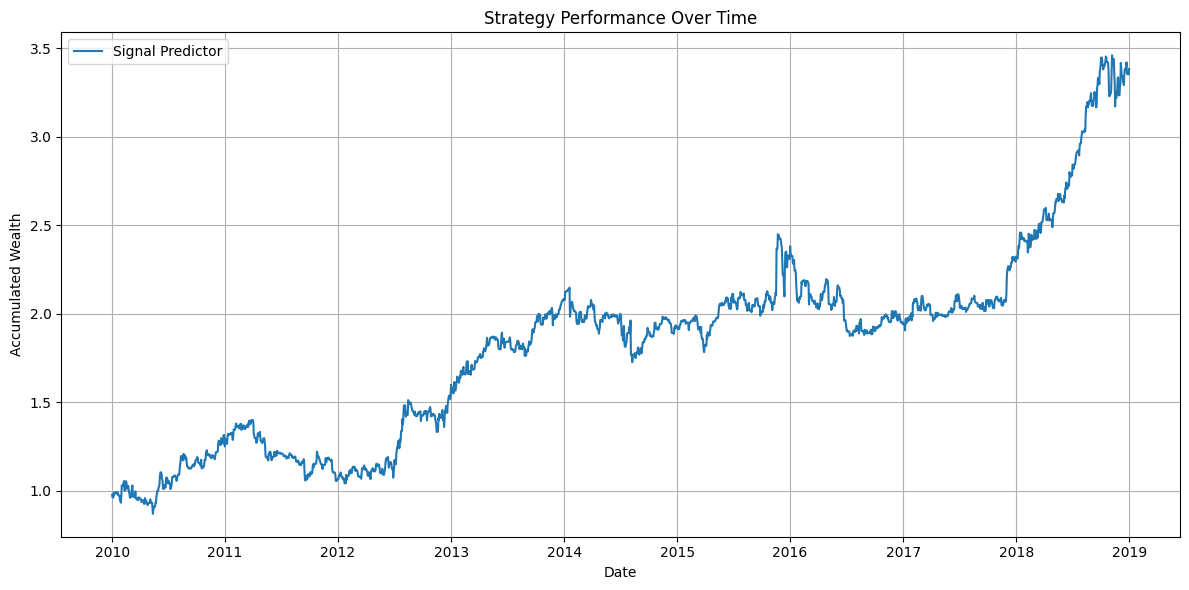

In [7]:
plot_cumulative_wealth(
    returns_dict={
        'Signal Predictor': realized_returns,
    }, 
    start_time=config.data_config.val_set_last_date, 
    end_time=config.data_config.end
)

In [8]:
realized_returns_attention_no_embed = realized_returns
pd.Series(realized_returns_attention_no_embed).to_csv('realized_returns_attention_embed.csv')